In [21]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from helper_functions import plot_compressed_image

**Problem Statement 1**

Implement K-means clustering and use it to produce a plot.

First, we create a function `find_closest_centroids()`. This function takes the data matrix `X` and the locations of all centroids inside `centroids`.It should output a one-dimensional array `idx` that holds the index of the closest centroid to every training example. For every example $x^{(i)}$ we set:

$$c^{(i)} := j \quad \mathrm{that \; minimizes} \quad ||x^{(i)} - \mu_j||^2,$$
where 
 * $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$ (corresponds to `idx[i]`)
 * $\mu_j$ is the position (value) of the $j$’th centroid. (stored in `centroids` in the starter code)
 * $||x^{(i)} - \mu_j||$ is the L2-norm

In [22]:
def find_closest_centroids(X: ndarray, centroids: ndarray) -> ndarray:
    """
    Computes the centroid memberships for every example.

    Args:
        X (ndarray): (m, n) Input values.
        centroids (ndarray): (K, n) centroids.

    Returns:
        idx (ndarray): (m,) closest centroids.
    """
    idx = np.array([
        np.argmin(np.sum(np.abs(X[i] - centroids), axis=1) ** 2)
        for i in range(len(X))
    ])
    return idx

assert np.allclose(
    find_closest_centroids(np.array([[-1, -1], [-1.5, -1.5], [-1.5, -1],
        [2, 2],[2.5, 2.5],[2, 2.5]]), np.array([[-1, -1], [2, 2]])),
    [0, 0, 0, 1, 1, 1]
)

Next, we create the `compute_centroids()` function to recompute the centroids. Specifically, for every centroid $\mu_k$ we set
$$\mu_k = \frac{1}{|C_k|} \sum_{i \in C_k} x^{(i)}$$ 

where 
* $C_k$ is the set of examples that are assigned to centroid $k$
* $|C_k|$ is the number of examples in the set $C_k$


* Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k=2$,
then you should update $\mu_2 = \frac{1}{2}(x^{(3)}+x^{(5)})$.

In [23]:
def compute_centroids(X: ndarray, idx: ndarray, K: int) -> ndarray:
    """
    Computes new centroids by computing the means of each centroid.

    Args:
        X (ndarray): (m, n) Data points.
        idx (ndarray): (m,) Index of closest centroid for each example in X.
        K (int): number of centroids.

    Returns:
        centroids (ndarray): (K, n) New centroids computed.
    """
    n = X.shape[1]
    centroids = np.zeros((K, n))

    for k in range(K):
        C = X[idx == k]
        new_center = np.sum(C, axis=0) / len(C)
        centroids[k] = new_center
    return centroids

assert np.allclose(
    compute_centroids(np.array([
        [2, 2.5], [2.5, 2.5], [-1.5, -1.5], [2, 2], [-1.5, -1], [-1, -1]]),
        np.array([0, 0, 1, 0, 1, 1]), 2),
    np.array([[[ 2.16666667,  2.33333333], [-1.33333333, -1.16666667]]])
)

The next step is to create a function to run K-means clustering and a function to initialize the initial centroids.

In [24]:
def run_kMeans(
    X: ndarray, initial_centroids: ndarray, max_iters=10
) -> tuple[ndarray, ndarray]:
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example

    Args:
        X (ndarray): (m, n) Data points.
        initial_centroids (ndarray): (K, n) centroids.
        max_iters (int, optional): Iterations of the algorithm. Defaults to 10.

    Returns:
        tuple[ndarray, ndarray]: Centroids and index of closest centroid.
    """
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros(m)
    plt.figure(figsize=(8, 6))

    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, K)
    return centroids, idx

In [25]:
def kMeans_init_centroids(X: ndarray, K: int) -> ndarray:
    """
    This function initializes K centroids that are to be
    used in K-Means on the dataset X

    Args:
        X (ndarray): Data points
        K (int):     number of centroids/clusters

    Returns:
        centroids (ndarray): Initialized centroids
    """

    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])

    # Take the first K examples as centroids
    centroids = X[randidx[:K]]
    return centroids

Finally, we use the functions implemented above to generate a plot:

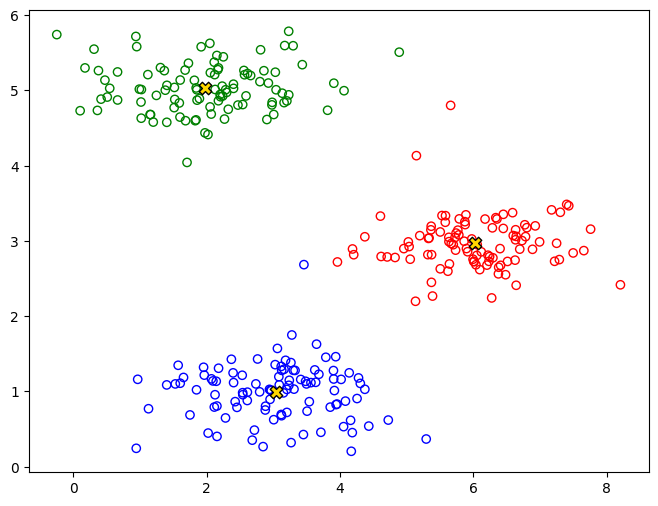

In [26]:
X = np.load("data/clustering1.npy")
assert X.shape == (300, 2)

# Get initial centroids, then run K-Means
initial_centroids = kMeans_init_centroids(X, 3)
centroids, idx = run_kMeans(X, initial_centroids, 25)

# Plot result
cmap = ListedColormap(["red", "green", "blue"])
plt.scatter(X[:, 0], X[:, 1], facecolors='none', color=cmap(idx))
plt.scatter(
    centroids[:, 0], centroids[:, 1], marker='X',
    color='gold', edgecolors='black', s=80)

**Problem statement 2**

Apply K-means in image compression. The goal is to reduce a 24-bit color image into an image that only contains 16 colors. This reduction, makes it possible to represent (compress) the photo in a more efficient way. 

<br>
Every pixel in the original image will be used as a data example and for the K-means algorithm. This will produce 16 clusters (colors) that best group the pixels in the 3-dimensional RGB space. Once the clusters have been computed, they will be used to replace the pixels in the original image.


Shape of original_img is: (128, 128, 3)


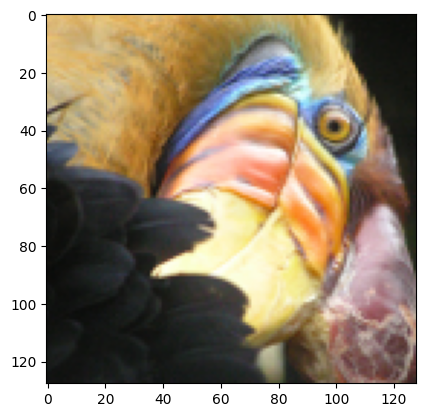

In [27]:
original_img = plt.imread('images/bird_small.png')
plt.imshow(original_img)
print("Shape of original_img is:", original_img.shape)

To call the `run_kMeans`, we need to first transform the matrix `original_img` into a two-dimensional matrix which is a $m \times 3$ matrix of pixel colors (where
$m = $ number of pixels).

In [28]:
X_img = np.reshape(original_img, (original_img.shape[0] * original_img.shape[1], 3))

Then, we run the K-means algorithm and extract the 16 colors that are going to be used for compression. After finding the top $K=16$ colors, we can then assign each pixel position to its closest centroid using the `find_closest_centroids` function. 

<br>

The original image required 24 bits (i.e. 8 bits x 3 channels in RGB encoding) for each one of the $128\times128$ pixel locations, resulting in total size of $128 \times 128 \times 24 = 393,216$ bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore $16 \times 24 + 128 \times 128 \times 4 = 65,920$ bits, which corresponds to compressing the original image by about a factor of 6.

<Figure size 800x600 with 0 Axes>

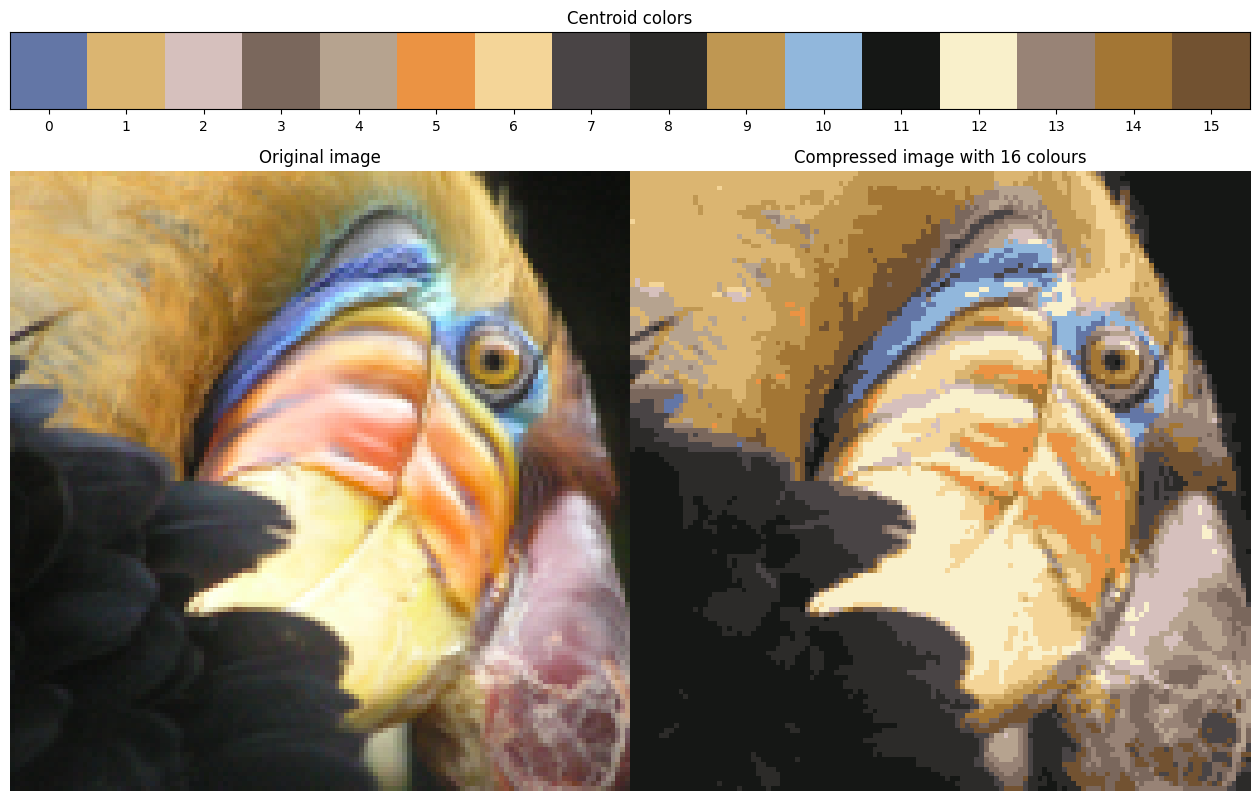

In [29]:
initial_centroids = kMeans_init_centroids(X_img, 16)
centroids, idx = run_kMeans(X_img, initial_centroids, 25)

# Replace each pixel with the color of the closest centroid
idx = find_closest_centroids(X_img, centroids)
compressed_img = np.reshape(centroids[idx, :], original_img.shape)

# Plot compressed image alongside the original image and color palette
plot_compressed_image(original_img, compressed_img, centroids)